In [1]:
import json
from sc3D import Embryo
from IPython.display import display

with open('data/corresptissues.json') as f:
    corres_tissues = json.load(f)
    corres_tissues = {eval(k): v for k, v in corres_tissues.items()}
with open('data/tissuescolor.json') as f:
    colors_paper = json.load(f)
    colors_paper = {eval(k): v for k, v in colors_paper.items()}
%matplotlib inline

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# Setting up parameters

In [2]:
# Path to the input data
data_path = 'local.h5ad'
# Path to the output folder
output_folder = 'out/'

# Set of genes that will be interpolated
genes_of_interest = ['Cck', 'Cnn1', 'Hbb-bh1', 'Nppa', 'Nppb', 'Tdgf1', 'Thbs4', 'Tnni3']

# List of tissues that are ignored to do coverslip registration
tissues_to_ignore = [13, 15, 16, 22, 27, 29, 32, 36, 40, 41]

# Coverslips to ignore
# on the starting side
nb_CS_begin_ignore = 0
# on the ending side
nb_CS_end_ignore = 2

# Gives more weight to some tissues to help the alignment
tissue_weight = {21:1000, 18:1}
# xy resolution
xy_resolution = .6
# Distance max that two beads can be linked together between coverslips
th_d = 150
# Threshold bellow which the beads will be considered noise.
# Value between 0 (all beads taken) and 1 (almost no beads taken)
outlier_threshold = .1

# Number of interpolated layers between two consecutive coverslips
nb_interp = 5

# Loading the embryo

In [3]:
embryo = Embryo(data_path, tissues_to_ignore, corres_tissues, tissue_weight=tissue_weight,
                xy_resolution=xy_resolution, genes_of_interest=genes_of_interest,
                nb_CS_begin_ignore=nb_CS_begin_ignore, nb_CS_end_ignore=nb_CS_end_ignore,
                store_anndata=True)
embryo.removing_spatial_outliers(th=outlier_threshold)
embryo.reconstruct_intermediate(embryo, th_d=th_d, genes=genes_of_interest)

/home/guignard/miniconda3/envs/sc3D/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/guignard/miniconda3/envs/sc3D/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


### Pre-processing the differential expression values
It can take a decent amount of time.

Moreover, it is likely that using a computer with decent amount of RAM is better

The list `tissues_to_process` contains the list of tissue ids that will be processed.

`th_vol` relates to the ratio of expressing cells over total number of cells for a given tissue. Any gene that have an expression volume ratio lower than `th_vol` or higher than `1-th_vol` is discarded.

`all_genes` specify if one wants to work to either all the genes (using the `anndata.raw` array) or "only" the variable genes identified by the previous analysis.

Setting `th_vol` to `0` will consider all the genes. **It is not recommended since it will consider a lot of genes that are either not expressed at all or genes that are expressed everywhere.**

A value of `0.025` as in the following example means that the gene expression volume has to be higher than 2.5% and lower than 98.5% of the total volume of the tissue.

The function `get_3D_differential_expression` returns a Pandas dataframe that one could work with if wanted.

This dataframe can also be found later at `embryo.diff_expressed_3D`.

In [4]:
tissues_to_process = [5, 10, 12, 18, 21, 24, 30, 31, 33, 34, 39]
th_vol = .025
_ = embryo.get_3D_differential_expression(tissues_to_process, th_vol, all_genes=False);

/home/guignard/miniconda3/envs/sc3D/lib/python3.8/site-packages/sc3D/sc3D.py:1203: RuntimeWarning: invalid value encountered in true_divide
  mean1 = np.cumsum(hist * bin_centers) / weight1
/home/guignard/miniconda3/envs/sc3D/lib/python3.8/site-packages/sc3D/sc3D.py:1204: RuntimeWarning: invalid value encountered in true_divide
  mean2 = (np.cumsum((hist * bin_centers)[::-1]) / weight2[::-1])[::-1]


If one wants to add a tissue to the set of tissues already treated, it can be done easily and will be much faster since all the pre-processing is stored.

In [5]:
_ = embryo.get_3D_differential_expression([30], th_vol, all_genes=False);

### Plotting the top `nb_genes` differentially expressed
The method `plot_top_3D_diff_expr_genes` allows to plot the top `nb_genes` that are spatially differentially expressed in a set of tissues `tissues_to_process`.

One can also allow or not gene repetition by changing the argument `repetition_allowed` from `False` to `True`. The default value is `False` meaning that repetitions are **not** allowed.

One can also decide to plot the original values or the z-scored values by changing the argument `compute_z_score`. Its value is `True` by default meaning that the z-score is plotted.

Ultimately, one can provide a matplotlib figure and a matplotib axis through the arguments `fig` and `ax`. By default none are specified and they are created within the function and returned by the function.

You asked to plot tissue(s) that were not already processed
The following tissue(s) will be ignored:
	 - id: 32, name: angioblasts


/home/guignard/miniconda3/envs/sc3D/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


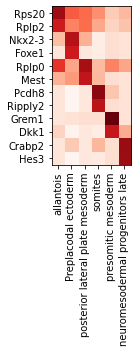

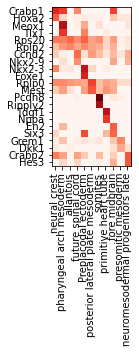

In [6]:
# Note that not all the tissues have to be plotted. Also, if a tissue asked
# has not already been computed, the function informs the user about it.
embryo.plot_top_3D_diff_expr_genes(tissues_to_process[:4]+[30, 31, 32], nb_genes=2);

# All the tissues plotted, 4 genes per tissues, repetition allowed,
# and the original values are plotted (not z-scored)
fig, ax = embryo.plot_top_3D_diff_expr_genes(tissues_to_process, nb_genes=2,
                                             repetition_allowed=False, compute_z_score=False,
                                             output_path='out/3D_diff_expr.pdf');

### Other visualization tools
Two other functions allow to visualize the 3D differentially expressed genes.

First `plot_volume_vs_neighbs` which allows to the relative volume occupied by expressing cells against their relative density for a given tissue.

The second function, `print_diff_expr_genes` allow to print the top `nb` genes for a given tissue

---
The function `plot_volume_vs_neighbs` takes as arguments at least a tissue `id`.

On top of that can be given a list of genes to identify on the plot through the argument `print_genes`.

The top _x_ genes can also be identified using the argument `print_top`

An `output_path` to the file in which to save the generated figure can be provided too.

Moreover, one can add keyword arguments to the function that will be forwarded to the `scatterplot` function from Seaborn. (see example below)

---
The function `print_diff_expr_genes` takes as arguments the tissue to display and the number of top genes to display

,Volume ratio,Avg #Neighbors ratio,Localization score,Interesting gene row ID,Gene names
1896,0.080537,0.134823,0.210972,4263,Crabp2
3710,0.144855,0.164368,0.210003,9634,Hes3
1878,0.102908,0.141108,0.202077,4230,Cpn1
8644,0.038591,0.105090,0.189169,18695,Trap1a
7544,0.233781,0.193059,0.182591,16772,Slc2a1
3836,0.220358,0.178697,0.165221,9847,Hoxb9
2037,0.455817,0.288440,0.165058,4519,Cyp26a1
4072,0.165548,0.152515,0.163895,10311,Irx3
6513,0.072707,0.107958,0.161203,14543,Ptprz1
2675,0.124720,0.132164,0.161088,5612,Epcam


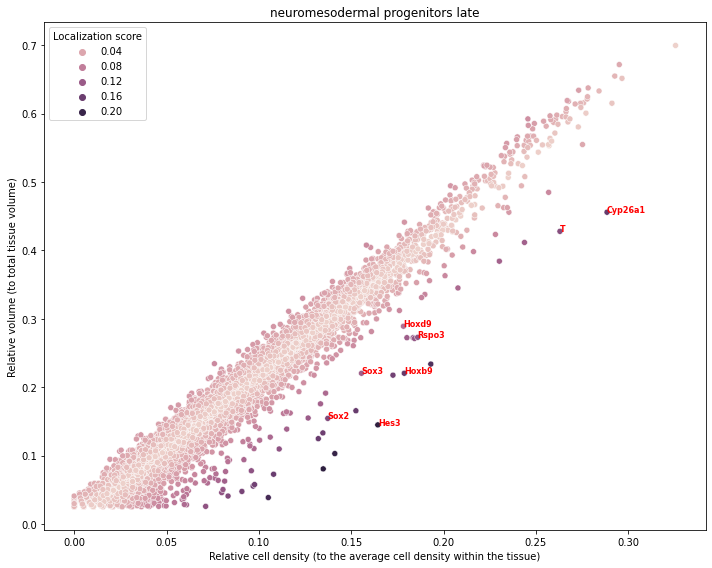

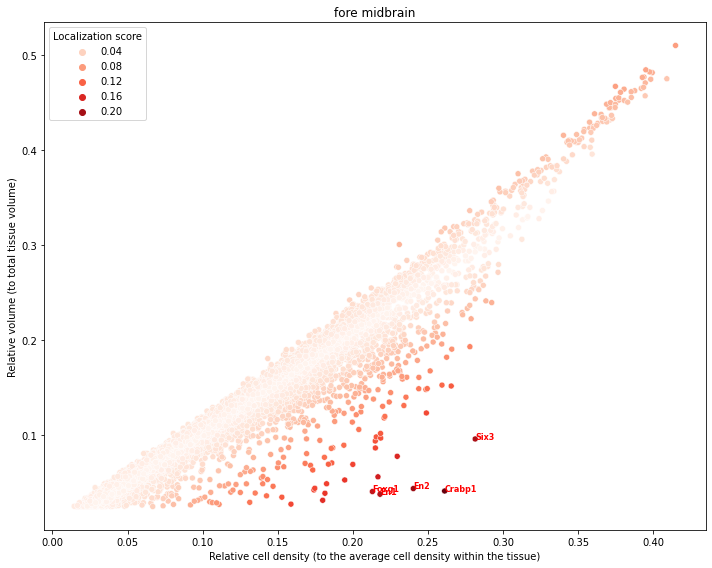

In [7]:
# Plotting the distribution for the tissue 31 highlighting a given set of genes
# and saving the figure in Vol_vs_Dens_31.pdf (note that a different path can be provided)
embryo.plot_volume_vs_neighbs(31, print_genes=['T', 'Sox2', 'Sox3',
                                               'Hes3', 'Hoxb9', 'Cyp26a1',
                                               'Rspo3', 'Hoxd9'],
                              output_path=f'out/Vol_vs_Dens_31.pdf')

# Plotting the distribution for the tissue 24 highlighting the top 5 genes.
# Note that the figure is not saved and that the palette arguments allows
# to give a different colormap for localization score.
embryo.plot_volume_vs_neighbs(24, print_top=5,
                              palette='Reds')

# Compute and display the top 10 genes for the tissue 31.
top_10 = embryo.print_diff_expr_genes(tissue=31, nb=10)
display(top_10)